<a href="https://colab.research.google.com/github/vahidzad/When-Computer-vision-meets-Electromagnetics/blob/main/FDTD-AIExplain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls '/content/drive/My Drive/Colab Notebooks/Vision/'

Abs-1d.txt	Features-1d.txt  Runtime-1d.txt  Shap_1layer
Abs-2d.txt	Features-2d.txt  Runtime-2d.txt  Shap_2layer
Abs-3d.txt	Features-3d.txt  Runtime-3d.txt  Shap_3layer
Cross_sections	Final_Models	 Shap		 Wavelength.txt


In [7]:
Index_address = '/content/drive/My Drive/Colab Notebooks/Vision/Raw_indecies/'
images_dir = '/content/drive/My Drive/Colab Notebooks/Vision/Cross_sections'
Result1D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-1d.txt'
Result2D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-2d.txt'
Result3D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-3d.txt'

In [8]:
#Classifier Results
Result1D = pd.read_csv(Result1D_adress, sep='\t', header = None,engine='python')
Result2D = pd.read_csv(Result2D_adress, sep='\t', header = None,engine='python')
Result3D = pd.read_csv(Result3D_adress, sep='\t', header = None,engine='python')
Results = pd.concat([Result1D, Result2D,Result3D])
Results = Results.drop([0],axis=1)  # get rid of the number of layers for now
Results_classification = Results.drop([8,9,10],axis=1)

In [9]:
Results_classification.head()

,1,2,3,4,5,6,7
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [10]:
for i in range (7):
  print('the number of instnaces in class ' + str(i+1) + ' is: ', Results_classification[i+1].value_counts()  )

the number of instnaces in class 1 is:  1    1213
0    1213
Name: 1, dtype: int64
the number of instnaces in class 2 is:  0    1213
1    1213
Name: 2, dtype: int64
the number of instnaces in class 3 is:  0    1684
1     742
Name: 3, dtype: int64
the number of instnaces in class 4 is:  0    1684
1     742
Name: 4, dtype: int64
the number of instnaces in class 5 is:  0    1684
1     742
Name: 5, dtype: int64
the number of instnaces in class 6 is:  0    1676
1     750
Name: 6, dtype: int64
the number of instnaces in class 7 is:  0    1676
1     750
Name: 7, dtype: int64


In [11]:
Results_classification.shape

(2426, 7)

In [ ]:
#Loading the images (Features) for Regression
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import cv2

Features2 = []

for i in tqdm(range(Results.shape[0])):
  path = images_dir +'/'+ str(i+1) + '.jpg'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.0
  img = cv2.resize(img, (108, 72), interpolation = cv2.INTER_AREA) 
  Features2.append(img)
Features2 = np.array(Features2)

100%|██████████| 2426/2426 [08:47<00:00,  4.60it/s]


In [27]:
#PPRN Results
Result1D = pd.read_csv(Result1D_adress, sep='\t', header = None,engine='python')
Result2D = pd.read_csv(Result2D_adress, sep='\t', header = None,engine='python')
Result3D = pd.read_csv(Result3D_adress, sep='\t', header = None,engine='python')
Results = pd.concat([Result1D, Result2D,Result3D])
Results_classification_regression = Results.drop([0],axis=1)  # get rid of the number of layers for now
Results_classification_regression[[8,9,10]] = Results_classification_regression[[8,9,10]]*1E9


In [28]:
Results_classification_regression.tail()

,1,2,3,4,5,6,7,8,9,10
1495,0,1,0,0,1,0,1,25.0,25.0,5.0
1496,0,1,0,0,1,0,1,25.0,25.0,10.0
1497,0,1,0,0,1,0,1,25.0,25.0,15.0
1498,0,1,0,0,1,0,1,25.0,25.0,20.0
1499,0,1,0,0,1,0,1,25.0,25.0,25.0


In [25]:
#Loading the images (Features) for PPRN 
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import cv2

Features3 = []

for i in tqdm(range(Results.shape[0])):
  path = images_dir +'/'+ str(i+1) + '.jpg'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.0
  img = cv2.resize(img, (108, 72), interpolation = cv2.INTER_AREA) 
  Features3.append(img)
Features3 = np.array(Features3)

100%|██████████| 2426/2426 [00:08<00:00, 292.14it/s]


In [29]:
#splitting the data to train and test for PPRN
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(Features3, Results_classification_regression, random_state = 0, test_size = 0.2)
y_train31 =  y_train3.drop([8,9,10],axis=1).values   #for classification
y_test31 =  y_test3.drop([8,9,10],axis=1).values   #for classification
y_train32 =  y_train3.drop([1,2,3,4,5,6,7],axis=1).values   #for Regression
y_test32 =  y_test3.drop([1,2,3,4,5,6,7],axis=1).values   #for Regression

In [35]:
#defining the architecture of PPRN
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from keras.layers import BatchNormalization
LaekyRelu = tf.keras.layers.LeakyReLU(alpha=0.2)
tanh = tf.keras.activations.tanh
relu = tf.keras.activations.relu


#### 
input = Input(shape=(X_train3[0].shape))              
layer1 = Conv2D(64,(3,3), activation=relu)(input)
#BatchNormalization1 = BatchNormalization()(layer1)
MaxPooling1 = MaxPooling2D((2,2))(layer1)


layer2 = Conv2D(64,(3,3), activation=relu)(MaxPooling1)
#BatchNormalization2 = BatchNormalization()(layer2)
MaxPooling2 = MaxPooling2D((2,2))(layer2)


#Classification

CLF1 = Conv2D(32,(3,3), activation=relu)(MaxPooling2)
#BatchNormalization_CLF1 = BatchNormalization()(CLF1)
MaxPooling_CLF1 = MaxPooling2D((2,2))(CLF1)
drop_CLF1 = Dropout(0.20)(MaxPooling_CLF1)

Flatten_CLF = Flatten()(drop_CLF1)

CLF = Dense(7, activation='sigmoid', name='classification')(Flatten_CLF)


#Regression
REG1 = Conv2D(64,(3,3), activation=relu)(MaxPooling2)
#BatchNormalization_REG1 = BatchNormalization()(REG1)
MaxPooling_REG1 = MaxPooling2D((2,2))(REG1)

REG2 = Conv2D(64,(3,3), activation=relu)(MaxPooling_REG1)
#BatchNormalization_REG1 = BatchNormalization()(REG1)
MaxPooling_REG2 = MaxPooling2D((2,2))(REG2)

'''
REG2 = Conv2D(64,(3,3), activation='tanh')(drop_REG1)
MaxPooling_REG2 = MaxPooling2D((2,2))(REG2)
drop_REG2 = Dropout(0.20)(MaxPooling_REG2)

'''
Flatten_REG = Flatten()(MaxPooling_REG2)

REG = Dense(3, activation='linear', name='regression')(Flatten_REG)

model3 = Model(input, outputs=[CLF, REG])

model3.compile(loss={'classification': 'binary_crossentropy', 
                    'regression': 'mae'},
              loss_weights={'classification': 0.1,
                            'regression': 0.9},
              optimizer=Adam(learning_rate=0.001),  #learning_rate=0.0001
              metrics={'classification': 'binary_accuracy', 'regression': 'mae'})

In [33]:
#starting the learning for PPRN
from keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()     
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto',baseline=None, restore_best_weights=False)

history3 = model3.fit(X_train3, [y_train31,y_train32],epochs=1500,validation_split=0.2,callbacks=callback,verbose=1)

Epoch 1/1500
49/49 [==============================] - 3s 30ms/step - loss: 8.6686 - classification_loss: 0.6578 - regression_loss: 9.5587 - classification_binary_accuracy: 0.6350 - regression_mae: 9.5587 - val_loss: 7.9184 - val_classification_loss: 0.6417 - val_regression_loss: 8.7269 - val_classification_binary_accuracy: 0.6410 - val_regression_mae: 8.7269
Epoch 2/1500
49/49 [==============================] - 1s 16ms/step - loss: 7.5023 - classification_loss: 0.6197 - regression_loss: 8.2670 - classification_binary_accuracy: 0.6602 - regression_mae: 8.2670 - val_loss: 7.0906 - val_classification_loss: 0.5778 - val_regression_loss: 7.8142 - val_classification_binary_accuracy: 0.6937 - val_regression_mae: 7.8142
Epoch 3/1500
49/49 [==============================] - 1s 17ms/step - loss: 6.6970 - classification_loss: 0.5533 - regression_loss: 7.3796 - classification_binary_accuracy: 0.6927 - regression_mae: 7.3796 - val_loss: 6.1933 - val_classification_loss: 0.5216 - val_regression_loss

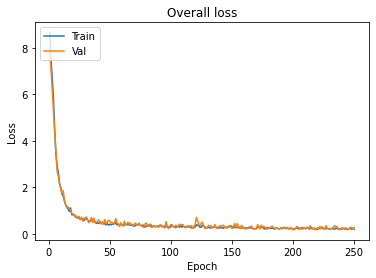

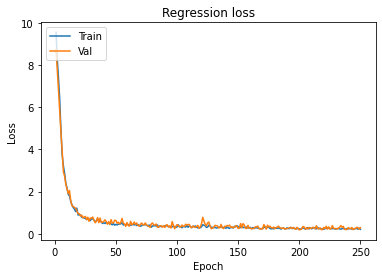

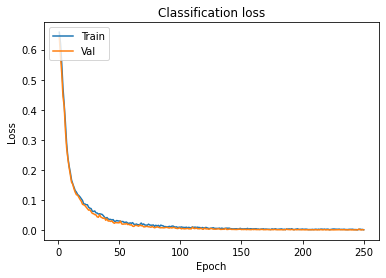

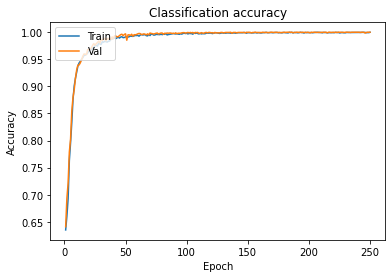

In [34]:
def plot_learningCurve(history, epoch):
  epoch_range = range(1, epoch+1)

  # Plot training & validation loss values
  plt.plot(epoch_range, history3.history['loss'])
  plt.plot(epoch_range, history3.history['val_loss'])
  plt.title('Overall loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history3.history['regression_loss'])
  plt.plot(epoch_range, history3.history['val_regression_loss'])
  plt.title('Regression loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history3.history['classification_loss'])
  plt.plot(epoch_range, history3.history['val_classification_loss'])
  plt.title('Classification loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()


  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history3.history["classification_binary_accuracy"])
  plt.plot(epoch_range, history3.history["val_classification_binary_accuracy"])
  plt.title('Classification accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()


plot_learningCurve(history3, len(history3.history['loss']))

In [ ]:
#saving PPRN model
#model3.save('Vision_classifier_regressor_small.h5')

In [36]:
i = 12
print(model3.predict(X_test3[i].reshape(1,72, 108,3)))   #72, 108
print(y_test31[i,:])
print(y_test32[i,:])

[array([[0.5009216 , 0.5283426 , 0.49463746, 0.5039062 , 0.5439312 ,
        0.465622  , 0.5180835 ]], dtype=float32), array([[0.1476212 , 0.03733537, 0.10532039]], dtype=float32)]
[0 1 1 0 0 0 1]
[25. 20. 15.]


In [ ]:
#pd.set_option('display.max_rows', None)
#pd.DataFrame(history3.history['val_classification_loss'])

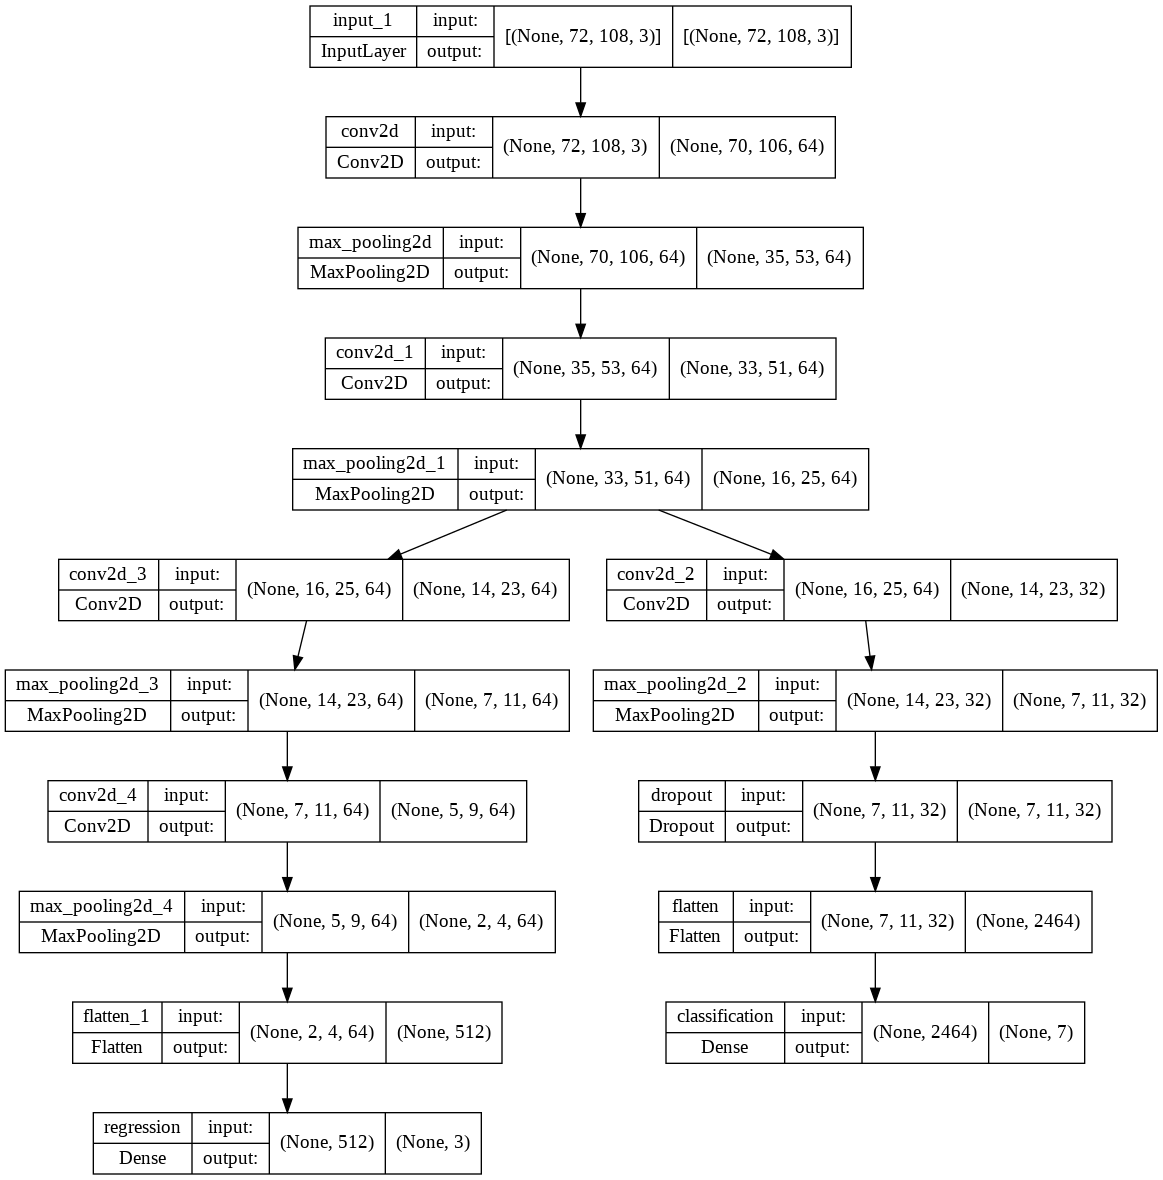

In [39]:
#loading the saved PPRN model and visualizing it
PPRN =  tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Vision/Final_Models/Vision_classifier_regressor_small.h5')
tf.keras.utils.plot_model(PPRN, show_shapes=True,show_layer_names=True, rankdir='TB')


In [40]:
PPRN.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 108, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 70, 106, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 35, 53, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 33, 51, 64)   36928       ['max_pooling2d[0][0]'

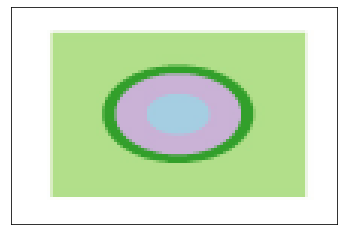

In [41]:
#visualizing the output of the randomly selected layers of PPRN

inter_model1 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('conv2d').output)
inter_model2 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('max_pooling2d').output)

inter_model3 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('conv2d_1').output)
inter_model4 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('max_pooling2d_1').output)

inter_model5 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('conv2d_2').output)  #classification specific 
inter_model6 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('max_pooling2d_2').output)

inter_model7 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('conv2d_3').output) #regression specific
inter_model8 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('max_pooling2d_3').output)

inter_model9 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('conv2d_4').output) #regression specific
inter_model10 = tf.keras.Model(inputs=PPRN.input,outputs=PPRN.get_layer('max_pooling2d_4').output)



i =2
output1 = inter_model1.predict(X_test3[i].reshape(1,72, 108,3)).reshape(70, 106, 64)
output2 = inter_model2.predict(X_test3[i].reshape(1,72, 108,3)).reshape(35, 53, 64)

output3 = inter_model3.predict(X_test3[i].reshape(1,72, 108,3)).reshape(33, 51, 64)
output4 = inter_model4.predict(X_test3[i].reshape(1,72, 108,3)).reshape(16, 25, 64)

output5 = inter_model5.predict(X_test3[i].reshape(1,72, 108,3)).reshape(14, 23, 32)
output6 = inter_model6.predict(X_test3[i].reshape(1,72, 108,3)).reshape(7, 11, 32)

output7 = inter_model7.predict(X_test3[i].reshape(1,72, 108,3)).reshape(14, 23, 64)
output8 = inter_model8.predict(X_test3[i].reshape(1,72, 108,3)).reshape(7, 11, 64)

output9 = inter_model9.predict(X_test3[i].reshape(1,72, 108,3)).reshape(5, 9, 64)
output10 = inter_model10.predict(X_test3[i].reshape(1,72, 108,3)).reshape(2, 4, 64)

plt.imshow(X_test3[i])
plt.xticks([])
plt.yticks([])
plt.savefig('sample.png', dpi=1000 , bbox_inches='tight')

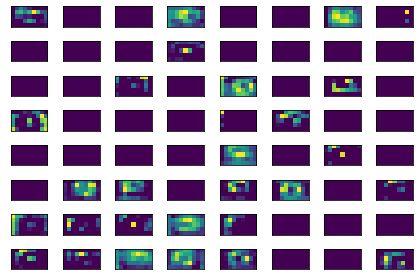

In [43]:
#visualizing the output of the randomly selected layers of PPRN using a randomly selected input (i)
for j in range(1, 65):
  plt.subplot(8, 8, j)
  opt = output9
  m=int(opt.shape[2]/4)
  plt.imshow(opt[:, :,j-1])
  plt.xticks([])
  plt.yticks([])
  plt.tight_layout()
  


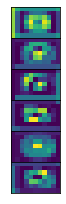

In [45]:
#visualizing the output of the randomly selected layers of PPRN using a randomly selected input 

for i,j in enumerate([3,9,10,28,33,59]):  #Layer1,2 = [1,2,7,35,51,60]  Layer3,4 = [3,12,26,48,57,63]  Layer5,6 = [13,14,15,26,27,32]  Layer7,8 =[3,9,10,28,33,59] Layer9,10 =[1,4,25,46,61,64]
  plt.subplot(7, 1, i+1)
  opt = output8
  plt.imshow(opt[:, :,j-1])
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(hspace=0.0, wspace=0.0)
#plt.savefig('layer8.png', dpi=1000 , bbox_inches='tight')

In [46]:
#######################################################################   Beginning of spectrum generator network (SGN)   #######################################################################################

In [47]:
Wavelength_adress='/content/drive/My Drive/Colab Notebooks/Vision/Wavelength.txt'
Abs_Result3D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Abs-3d.txt'
Abs_Result2D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Abs-2d.txt'
Abs_Result1D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Abs-1d.txt'
Feature1D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-1d.txt'
Feature2D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-2d.txt'
Feature3D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-3d.txt'

In [48]:
#Features for SGN network
Feature1D = pd.read_csv(Feature1D_adress, sep='\t', header = None,engine='python')
Feature2D = pd.read_csv(Feature2D_adress, sep='\t', header = None,engine='python')
Feature3D = pd.read_csv(Feature3D_adress, sep='\t', header = None,engine='python')
Features4 = pd.concat([Feature1D, Feature2D,Feature3D])
Features4 = Features4.drop([0],axis=1)  # get rid of the number of layers for now

Features4[8] = Features4[8].apply(lambda x: x*1E+9)
Features4[9] = Features4[9].apply(lambda x: x*1E+9)
Features4[10] = Features4[10].apply(lambda x: x*1E+9)

In [49]:
#Features for SGN network
Wavelength = pd.read_csv(Wavelength_adress, sep="\t", header=None)
Result3D = pd.read_csv(Abs_Result3D_adress, sep='\t', header = None,engine='python')
Result2D = pd.read_csv(Abs_Result2D_adress, sep='\t', header = None,engine='python')
Result1D = pd.read_csv(Abs_Result1D_adress, sep='\t', header = None,engine='python')
Results4 = pd.concat([Result1D,Result2D,Result3D],axis=1,ignore_index=True)*1E7

In [ ]:
Features4.shape

(2426, 10)

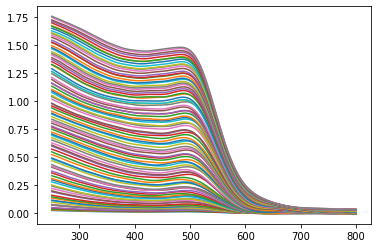

In [50]:
#visualizing a few of the absorption spectrum
for i in range(1,99):
  x = Results4[i]
  plt.plot(Wavelength,x)

In [51]:
#splitting the data to train and test for SGN network
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train4, X_test4, y_train4, y_test4 = train_test_split(Features4, Results4.T, random_state = 0, test_size = 0.2)
scaler = preprocessing.MinMaxScaler()

X_train4 = scaler.fit_transform(X_train4)
X_test4 = scaler.transform(X_test4)

Features_normalized4 = scaler.transform(Features4)
N, D = X_train4.shape

In [56]:
#defining the architecture of SGN

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
LeakyRelu = tf.keras.layers.LeakyReLU(alpha=0.2)
tanh = tf.keras.activations.tanh
relu = tf.keras.activations.relu


# Decoder Model
model4 = Sequential()
model4.add(Dense(1024, input_shape=(D,), activation=relu))
model4.add(Dense(1024, activation=relu))
#model4.add(Dense(64, activation=relu))
#model4.add(Dense(64, activation=LeakyRelu))

model4.add(Dense(200, activation='linear'))

In [57]:
#starting the learning for SGN
tf.keras.backend.clear_session()     
model4.compile(loss='mae', optimizer=Adam(lr=0.001), metrics=['accuracy']) #metrics=['accuracy']  loss='binary_crossentropy'  #metrics=['binary_accuracy'] metrics=[HammingLoss(threshold=0.5, mode='multilabel')]                                                                                      
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
history4 = model4.fit(X_train4, y_train4, validation_split=0.2,batch_size=32, epochs=1500,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/1500
49/49 [==============================] - 1s 7ms/step - loss: 0.2221 - accuracy: 0.0902 - val_loss: 0.1271 - val_accuracy: 0.0851
Epoch 2/1500
49/49 [==============================] - 0s 4ms/step - loss: 0.1016 - accuracy: 0.1546 - val_loss: 0.0874 - val_accuracy: 0.0979
Epoch 3/1500
49/49 [==============================] - 0s 5ms/step - loss: 0.0790 - accuracy: 0.1714 - val_loss: 0.0771 - val_accuracy: 0.1727
Epoch 4/1500
49/49 [==============================] - 0s 4ms/step - loss: 0.0721 - accuracy: 0.2610 - val_loss: 0.0761 - val_accuracy: 0.1753
Epoch 5/1500
49/49 [==============================] - 0s 4ms/step - loss: 0.0658 - accuracy: 0.2113 - val_loss: 0.0664 - val_accuracy: 0.1856
Epoch 6/1500
49/49 [==============================] - 0s 5ms/step - loss: 0.0615 - accuracy: 0.2062 - val_loss: 0.0631 - val_accuracy: 0.1778
Epoch 7/1500
49/49 [==============================] - 0s 4ms/step - loss: 0.0575 - accuracy: 0.2378 - val_loss: 0.0575 - val_accuracy: 0.1907
Epoch 

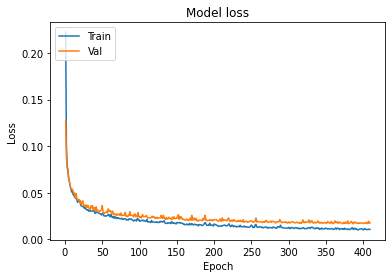

In [58]:
def plot_learningCurve(history, epoch):
  epoch_range = range(1, epoch+1)
  # Plot training & validation loss values
  plt.plot(epoch_range, history4.history['loss'])
  plt.plot(epoch_range, history4.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history4, len(history4.history['loss']))

In [ ]:
#saving the SGN model
#model4.save('Decoder.h5')

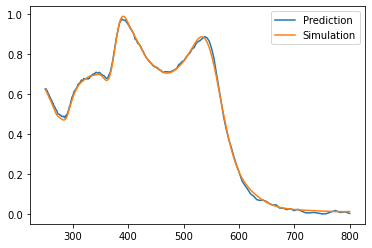

In [60]:
#visualizing the predition of SGN network VS a randomly selected simulation (i)
i=420
F = Features_normalized4[i].reshape((1,10))

Yhat = model4.predict(F)
plt.plot(Wavelength,Yhat.T)
plt.plot(Wavelength,Results4[i])
plt.legend(['Prediction', 'Simulation'])

In [68]:
#Loading the images 
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import cv2

sample = []

for i in tqdm(range(2426)):
  path = images_dir +'/'+ str(i+1) + '.jpg'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.0
  img = cv2.resize(img, (108, 72), interpolation = cv2.INTER_AREA) 
  sample.append(img)
sample = np.array(sample)

100%|██████████| 2426/2426 [00:08<00:00, 282.33it/s]


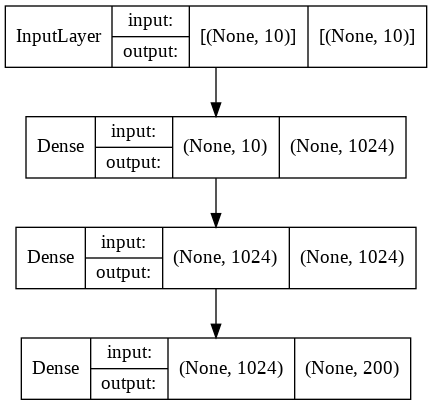

In [75]:
#loading the saved PPRN and SGD models and visualizing it
PPRN =  tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Vision/Final_Models/Vision_classifier_regressor_small.h5')
SGN = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Vision/Final_Models/Decoder.h5')
tf.keras.utils.plot_model(SGD, show_shapes=True,show_layer_names=False, rankdir='TB')

In [77]:
SGN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              11264     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 200)               205000    
                                                                 
Total params: 1,265,864
Trainable params: 1,265,864
Non-trainable params: 0
_________________________________________________________________


In [67]:
!pip install shap -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.0 MB/s 


In [ ]:
#######################################################################   Explaining the SGN using Shap values   #######################################################################################

In [78]:
#explaining SGN using shap values
import shap

#initialize js methods for visualization
shap.initjs()

# create an instance of the DeepSHAP which is called DeepExplainer
explainer_shap = shap.DeepExplainer(model=SGN,data=X_train4)

# Fit the explainer on a subset of the data (you can try all but then gets slower)
shap_values = explainer_shap.shap_values(X=X_train4[0:500,:],ranked_outputs=True,check_additivity=False)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


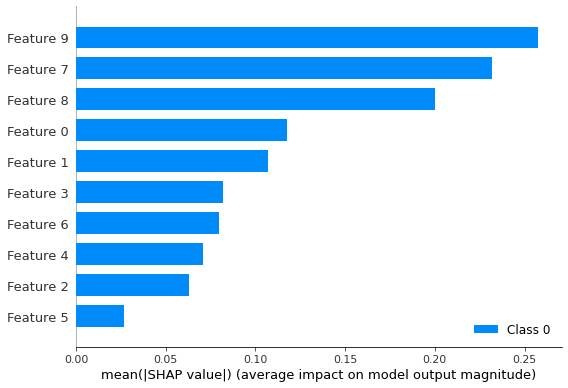

In [80]:
shap.summary_plot(shap_values[0], X_train4[0:500,:])

In [ ]:
import shap

explainer2 = shap.KernelExplainer(model = SGN.predict, data = X_train4, link = "identity")
shap_values2 = explainer2.shap_values(X=X_train4[0:500,:], nsamples = 100)

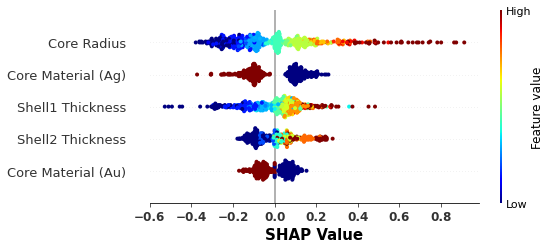

In [117]:
# Define colormap    # exotic 8-25
i=45
my_cmap = plt.get_cmap('jet')
shap_dir = '/content/drive/My Drive/Colab Notebooks/Vision/Shap'
shap.initjs()
plt.figure()
shap.summary_plot(shap_values = shap_values2[i],features = X_train4[0:500,:],show=False,feature_names = ['Core Material (Au)','Core Material (Ag)','Shell1 Material (TiO2)','Shell1 Material (Si)','Shell1 Material (Ge)','Shell2 Material (Au)','Shell2 Material (Ag)','Core Radius','Shell1 Thickness','Shell2 Thickness'],max_display=5,) 

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
plt.xlabel("SHAP Value",fontweight='bold',fontsize=15)
plt.xticks(fontsize=12,fontweight='bold',rotation='horizontal')
plt.savefig('90',dpi=300,bbox_inches='tight')